# Import libs

In [1]:
import sys
import os
sys.path.append('..')
from eflow.foundation import DataPipeline,DataFrameTypes
from eflow.data_analysis import FeatureAnalysis, NullAnalysis
from eflow.model_analysis import ClassificationAnalysis
from eflow.data_pipeline_segments import FeatureTransformer, TypeFixer, DataEncoder
from eflow.utils.modeling_utils import optimize_model_grid
from eflow.utils.eflow_utils import get_type_holder_from_pipeline, remove_unconnected_pipeline_segments
from eflow.utils.math_utils import get_unbalanced_threshold
from eflow.utils.sys_utils import create_dir_structure
from eflow.utils.eflow_utils import create_color_dict_for_features
from eflow.utils.pandas_utils import data_types_table, value_counts_table, suggest_removal_features, missing_values_table
from eflow.widgets import ColorLabelingWidget

import pandas as pd
import numpy as np
import scikitplot as skplt
from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import copy
from IPython.display import clear_output
from IPython.core.getipython import get_ipython
import ipython_blocking
import nltk

In [2]:
# # Additional add ons
# !pip install pandasgui
# !pip install pivottablejs
# clear_output()

In [3]:
%matplotlib notebook
%matplotlib inline

#### Download natural language processing utils

In [4]:
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Juypter notebook generating cells

### Important Note: Replace if set to True will remove all the contents of whatever cell it is called in. But it can be undone with a simple CMD + Z. 🙂

In [5]:
# Author: http://tinyurl.com/y6mghyzl
def create_new_cell(contents,
                    replace=False):
    """
    Desc:
        Creates a new jupyter cell.
    """
    shell = get_ipython()
    shell.set_next_input(contents,
                         replace=replace)

def __format_list_to_string(list_name,
                            list_contents):
    """
    Desc:
        Converts a list to a string and adds newlines for formating.
    """
    output_str = f"{list_name} = ["
    escape_seq_count = 0
    final_index = len(list_contents) - 1
    req_spacing = len(output_str)

    for i,element in enumerate(list_contents):
        if i == final_index:
            output_str += f'\"{element}\"'
        else:
            output_str += f'\"{element}\",'
        
        if len(output_str.split("\n")[escape_seq_count]) > 78:
            output_str += "\n"
            output_str += (" " * req_spacing)
            escape_seq_count += 1
    output_str += "]"
    return output_str

def create_new_cell_with_removal_features(df,
                                          replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested features to remove.
    
    Args:
        df:
            Pandas DataFrame object
            
        replace:
            Boolean to determine replacing the current cell.
    """
    
    # Get suggestions for removal
    cell_content = __format_list_to_string("removal_features",
                                           suggest_removal_features(df))
    # Add a sort of calling card of the function that created it
    cell_content = f"# create_new_cell_with_removal_features(df,replace={replace})\n" + cell_content
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_null_removal_features(df,
                                               null_threshold=.25,
                                               replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested features to remove based on nulls.
    
    Args:
        df:
            Pandas DataFrame object
            
        null_threshold:
            Any features that contain x% percent of nulls are suggested.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum() / len(df)
    # Add a calling card of the function that created it
    cell_content = f"# create_new_cell_with_null_removal_features(df,null_threshold={null_threshold},replace={replace})\n"
    cell_content += __format_list_to_string("remove_null_features",
                                             mis_val_percent[mis_val_percent >= null_threshold].index.to_list())
    
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_feature_value_color_dict(df,
                                                  df_features,
                                                  value_limit=50,
                                                  replace=True):
    """
    Desc:
        Creates a new cell block with a dict of suggested feature value colors.
    
    Args:
        df:
            Pandas DataFrame object
        
        df_features:
            DataFrameTypes object.
        
        null_threshold:
            Any features that contain x% percent of nulls are suggested.
            
        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    feature_value_color_dict = create_color_dict_for_features(df,
                                                              df_features,
                                                              value_limit)
    # Add a sort of calling card of the function that created it
    cell_content = ""
    cell_content += f"# create_new_cell_with_feature_value_color_dict(df,df_features,value_limit={value_limit},replace={replace})\n"
    cell_content += "feature_value_color_dict=dict()"
    feature_count = 0
    for feature_name, feature_value_color in feature_value_color_dict.items():
        if feature_value_color_dict[feature_name].keys(): 
            cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"] = dict()"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give colors to each!"
        
        for feature_value, color in feature_value_color.items():

            color = feature_value_color_dict[feature_name][feature_value]
            
            if feature_name in df_features.bool_features() or feature_name in df_features.categorical_features():
                try:
                    feature_value = int(float(feature_value))
                except:
                    pass
            
            if isinstance(feature_value,str):
                feature_value = f"\"{feature_value}\""
            else:
                feature_value = f"{feature_value}"
            
            if color is None:
                cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][{feature_value}] = \"\""
            else:
                cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][{feature_value}] = \"{color}\""
        cell_content += "\n"
        
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_categorical_dict(df,
                                          df_features,
                                          value_limit=50,
                                          replace=True):
    """
    Desc:
        Creates a new cell block with a dict of
    
    Args:
        df:
            Pandas DataFrame object

        df_features:
            DataFrameTypes object.

        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """

    cell_content = ""
    cell_content += f"# create_new_cell_with_categorical_dict(df,df_features,value_limit={value_limit},replace={replace})\n"
    cell_content += "categorical_value_dict = dict()\n"
    
    categorical_value_dict = dict()
    for feature_name in df_features.categorical_features():
        
        # Find and sort feature values
        feature_values = df[feature_name].value_counts(sort=False).index.to_list()
        feature_values = [str(val) for val in feature_values]
        feature_values.sort()
        
        # Create feature cat dict
        cat_found = False
        categorical_value_dict[feature_name] = dict()
        for val in feature_values:
            try:
                categorical_value_dict[feature_name][int(val)] = ""
                cat_found = True
            except ValueError:
                pass
        
        # Delete feature name if no categories are found
        if not cat_found:
            del categorical_value_dict[feature_name]
    
    for feature_name,cat_val_dict in categorical_value_dict.items():
        
        if len(cat_val_dict.keys()) < value_limit:
            cell_content += f"categorical_value_dict[\"{feature_name}\"]=dict()\n"
            for cat,val in cat_val_dict.items():

                if isinstance(val,str):
                    cell_content += f"categorical_value_dict[\"{feature_name}\"][{cat}] = \"{val}\"\n"
                else:
                    cell_content += f"categorical_value_dict[\"{feature_name}\"][{cat}] = {val}\n"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give encode to each!"

        

    create_new_cell(cell_content,
                    replace=replace)
    
    

def create_new_cell_with_value_representation(df,
                                              df_features,
                                              value_limit=50,
                                              replace=True):
    """
    Desc:
        Creates a new cell block with a dict of suggested feature value colors.
    
    Args:
        df:
            Pandas DataFrame object

        df_features:
            DataFrameTypes object.

        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    feature_value_representation = dict()
    for feature_name in df_features.string_features():
        feature_value_representation[feature_name] = dict()
        for val in df[feature_name].dropna().value_counts(sort=False).index.to_list():
            if isinstance(val,str):
                if len(val) == 0:
                    continue
                if len(val) <= 3 or val not in words.words():
                    feature_value_representation[feature_name][val] = ""

                if len(feature_value_representation[feature_name].keys()) >= 50:
                    break

        if not len(feature_value_representation[feature_name].keys()):
            del feature_value_representation[feature_name]
    cell_content = ""
    cell_content += f"# create_new_cell_with_value_representation(df,df_features,value_limit={value_limit},replace={replace})\n"
    
    cell_content += "feature_value_representation = dict()\n"
    for feature_name,val_repr_dict in feature_value_representation.items():
        
        if len(val_repr_dict.keys()) < value_limit:
            cell_content += f"feature_value_representation[\"{feature_name}\"] = dict()\n"
            for val,reprs in val_repr_dict.items():

                if isinstance(val,str):
                    cell_content += f"feature_value_representation[\"{feature_name}\"][\"{val}\"] = "
                else:
                    cell_content += f"feature_value_representation[\"{feature_name}\"][{val}] = "
                
                if isinstance(reprs,str):
                    cell_content += f"\"{reprs}\"\n"
                else:
                    cell_content += f"{reprs}\n"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give representation to to each!"
        
        cell_content += "\n"
    create_new_cell(cell_content,
                    replace=replace)

## Declare Project Variables

### Interaction required

In [6]:
dataset_path = "Datasets/Fee Configuration with User Input.csv"
dataset_name = "UserInput for Fee Configuration"

# -----
inspect_data_project_dir = f"{dataset_name}/Before Cleaning"

In [7]:
# -----
notebook_mode = True

# -----
display_value_counts = False

# Import dataset

In [8]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

,Rows,Columns
0,197,42


,fee_item_key_id,fee_item_type_id,effective_date_time,expiration_date_time,fee_item_desc,hud_section_type_id,hud_line_number,respa_block_id,summary_item_yn,summary_fee_item_type_id,...,include_on_provider_list_yn,allow_zero_value_yn,sort_value,escrow_item_yn,escrow_category_type_id,default_payee_to_provider_yn,default_provider_identifier,default_tolerance_type_id,explanation,can_finance_yn
0,203K_INSPECTION_FEE,203K_INSPECTION_FEE,NaN,NaN,203(k) Inspection Fee,800,811,3,0,CANNOT_SHOP,...,0.0,1,B,0,NaN,1.0,NaN,ZEROPCT,NaN,NaN
1,203K_SUPPLEMENTAL_ORIG_FEE,203K_SUPPLEMENTAL_ORIG_FEE,NaN,NaN,203(k) Supplemental Origination Fee,800,0801i,1,0,ORIGINATION,...,NaN,1,A,0,NaN,1.0,NaN,ZEROPCT,NaN,NaN
2,ABSTRACT_COPIES_FEE,ABSTRACT_COPIES_FEE,NaN,NaN,Abstract Copies Fee,1100,1112k,4,0,CAN_SHOP,...,1.0,1,C,0,NaN,1.0,NaN,TENPCT,NaN,NaN
3,ABSTRACT_SEARCH_FEE,ABSTRACT_SEARCH_FEE,NaN,NaN,Abstract or Title Search Fee,1100,1101a,4,0,CAN_SHOP,...,1.0,1,C,0,NaN,1.0,NaN,TENPCT,NaN,NaN
4,ABSTRACT_STORAGE_FEE,ABSTRACT_STORAGE_FEE,NaN,NaN,Abstract Storage Fee,1100,1111l,4,0,CAN_SHOP,...,1.0,1,C,0,NaN,1.0,NaN,TENPCT,NaN,NaN
5,ADDL_INSPECTION_FEE,ADDL_INSPECTION_FEE,NaN,NaN,Inspection Fees (optional),1300,1307,6,0,OTHER,...,1.0,1,H,0,NaN,1.0,NaN,NaN,NaN,NaN
6,ADMINISTRATION_FEE,ADMINISTRATION_FEE,NaN,NaN,Administration Fee,800,0801g,1,0,ORIGINATION,...,NaN,1,A,0,NaN,1.0,NaN,ZEROPCT,NaN,NaN
7,AGRICULTURAL_CONSERVATION_FEE,AGRICULTURAL_CONSERVATION_FEE,NaN,NaN,Agricultural Conservation Fee,1200,1209k,7,0,TAXES_GOV_FEES,...,NaN,1,E,0,NaN,1.0,NaN,TENPCT,NaN,NaN
8,AK_PROGRAM_ADMIN_FEE,AK_PROGRAM_ADMIN_FEE,NaN,NaN,AK Program Administration Fee,1100,1110a,4,0,CAN_SHOP,...,1.0,1,C,0,NaN,1.0,NaN,TENPCT,NaN,NaN
9,AMC_APPRAISAL_FEE,AMC_APPRAISAL_FEE,NaN,NaN,AMC Portion of Appraisal Fee,800,0804a,3,0,CANNOT_SHOP,...,NaN,1,B,0,NaN,1.0,NaN,ZEROPCT,NaN,NaN


In [9]:
data_types_table(df)

,Data Types
Features,
can_finance_yn,float64
fee_classification_type_id,float64
int_disc_section_type_id,float64
cascade_fee_provider_info_yn,float64
allow_freeform_provider_yn,float64
include_on_provider_list_yn,float64
fee_provider_type_change_yn,float64
default_payee_to_provider_yn,float64
expiration_date_time,float64


## Remove/Declare any unwanted features

### Interaction required

Note: When starting a new project uncomment the function to get suggestions and then run the cell again.

In [10]:
# create_new_cell_with_removal_features(df,replace=True)
removal_features = ["hud_line_number"]

In [11]:
df.drop(columns=removal_features,
        inplace=True)

<hr>

In [12]:
# create_new_cell_with_null_removal_features(df,null_threshold=1,replace=True)
remove_null_features = ["effective_date_time","expiration_date_time","default_provider_identifier",
                        "explanation","can_finance_yn"]

In [13]:
df.drop(columns=remove_null_features,
        inplace=True)

In [14]:
data_types_table(df)

,Data Types
Features,
allow_freeform_provider_yn,float64
cascade_fee_provider_info_yn,float64
int_disc_section_type_id,float64
fee_classification_type_id,float64
default_payee_to_provider_yn,float64
include_on_provider_list_yn,float64
fee_provider_type_change_yn,float64
loan_terms_sensitive_yn,int64
property_sensitive_yn,int64


## Gui tools for quick analysis dataframes

Great interface; pauses the program; comment on/off at free will.
You will need to reset kernel after use more than likely.

In [15]:
# from pandasgui import show as qt_display
# qt_display(df)
# %matplotlib inline

In [16]:
# pivot_ui(df,
#          outfile_path='Piviot_Table_JS.html')

# Any basic manipulation of features

#### What I mean by this is say you want to represent a feature slightly different than it is currently displaying.
Note: that whatever maniuplation you do here you should bring to each notebook's section of "Any basic manipulation of features"

## Skim through Value Counts

In [17]:
if display_value_counts:
    for feature_name in df.columns:
        print(f'******* Feature: {feature_name} *******')
        print(f'Type: {df[feature_name].dtype}')
        display(value_counts_table(df,
                                   feature_name))
        print("-------" * 4 + "\n\n")

# Mark target feature; set to None if not needed

### Interaction required

### Supervised learning problems (Can be set to None)

In [18]:
target_feature = "sort_value"

In [19]:
try:
    if target_feature:
        df[target_feature]
except KeyError:
    raise KeyError(f"The target feature \'{target_feature}\' was not found in the dataframe!"
                   + " Please select a valid feature from the dataframe")

In [20]:
if target_feature:
    print(f"Target feature '{target_feature}'")
    print("----" * 10)
    target_amount = len(df[target_feature].dropna().value_counts().index)
    value_count_df = value_counts_table(df,
                                        target_feature)
    if target_amount < 1:
        display(value_count_df)
    elif target_amount > 25:
        display(value_count_df)
        print("Value count is above 25 asserting that this is probably a continous data stream!")
    else:
        # Change arg 'max_binary_threshold' to see changes in threshold
        max_unbalanced_class_threshold, min_unbalanced_class_threshold = get_unbalanced_threshold(target_amount)
        
        print(f"max_unbalanced_class_threshold = {max_unbalanced_class_threshold * 100:.3f}%")
        print(f"min_unbalanced_class_threshold = {min_unbalanced_class_threshold * 100:.3f}%")
        display(value_count_df)
        index = 0
        for percentage in value_count_df["Percantage"]:
            percentage = float(percentage[:-1])/100
            if percentage >= max_unbalanced_class_threshold or percentage <= min_unbalanced_class_threshold:
                print(f"The value '{value_count_df.index.values[index]}' is causing the target feature to be unbalanced.\n" +
                      "This could cause a model to not properly generalize itself.")
                print("---" * 10 + "\n")

            index += 1

Target feature 'sort_value'
----------------------------------------
max_unbalanced_class_threshold = 18.571%
min_unbalanced_class_threshold = 13.571%


,Counts,Percantage
Unique Values,,
C,91,46.9072%
B,31,15.9794%
E,24,12.3711%
H,17,8.7629%
F,16,8.2474%
A,14,7.2165%
G,1,0.5155%


The value 'C' is causing the target feature to be unbalanced.
This could cause a model to not properly generalize itself.
------------------------------

The value 'E' is causing the target feature to be unbalanced.
This could cause a model to not properly generalize itself.
------------------------------

The value 'H' is causing the target feature to be unbalanced.
This could cause a model to not properly generalize itself.
------------------------------

The value 'F' is causing the target feature to be unbalanced.
This could cause a model to not properly generalize itself.
------------------------------

The value 'A' is causing the target feature to be unbalanced.
This could cause a model to not properly generalize itself.
------------------------------

The value 'G' is causing the target feature to be unbalanced.
This could cause a model to not properly generalize itself.
------------------------------



# Load/Init DataFrameTypes object.

This object is used to store an abstracted form of what a feature 'should be' rather than what the pandas dataframe object says it is. In this case we will be specifying all features correct types.

Comment out/remove depending on how you want your design flow to be.

In [21]:
df_features = DataFrameTypes(df,
                             ignore_nulls=True,
                             fix_numeric_features=True,
                             fix_string_features=True,
                             target_feature=target_feature,
                             notebook_mode=notebook_mode)

## Make any changes to 'df_features' that automated type assertions messed up.

Ex: Sometimes df_features will think a feature is a category when it isn't. Move to proper types.

In [22]:
print("df_features types:")
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

df_features types:


,Data Types
Features,
fee_item_type_id,string
fee_item_desc,string
default_tolerance_type_id,string
fee_paid_to_type_id,string
sort_value,string
escrow_category_type_id,string
fee_provider_type_id,string
summary_fee_item_type_id,string
fee_item_key_id,string


In [23]:
df_features.set_feature_to_bool(feature_name=[])
df_features.set_feature_to_integer(feature_name=[])
df_features.set_feature_to_float(feature_name=[])
df_features.set_feature_to_string(feature_name=[])
df_features.set_feature_to_datetime(feature_name=[])
df_features.set_feature_to_categorical(feature_name=[])

In [24]:
print("df_features types:")
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

df_features types:


,Data Types
Features,
fee_item_type_id,string
fee_item_desc,string
default_tolerance_type_id,string
fee_paid_to_type_id,string
sort_value,string
escrow_category_type_id,string
fee_provider_type_id,string
summary_fee_item_type_id,string
fee_item_key_id,string


In [25]:
print("Dataframe's types:")
data_types_table(df)

Dataframe's types:


,Data Types
Features,
allow_freeform_provider_yn,float64
cascade_fee_provider_info_yn,float64
int_disc_section_type_id,float64
fee_classification_type_id,float64
default_payee_to_provider_yn,float64
include_on_provider_list_yn,float64
fee_provider_type_change_yn,float64
loan_terms_sensitive_yn,int64
property_sensitive_yn,int64


# Colors and palletes for features

### Remove any unwanted values found or any unwanted features to be color coded.

In [42]:
# create_new_cell_with_feature_value_color_dict(df,df_features,value_limit=50,replace=True)

In [43]:
cleaning_widget = ColorLabelingWidget()
cleaning_widget.run_widget(feature_value_color_dict)

interactive(children=(Select(description='Features', layout=Layout(height='175px', width='50%'), options=('all…

### Reinitialize feature color dictionary

In [28]:
feature_value_color_dict = cleaning_widget.get_feature_value_color_dict()

In [29]:
feature_value_color_dict

{'refundable_fee_yn': {0: '#ff8585'},
 'item_paid_in_advance_yn': {0: '#ff8585', 1: '#55a868'},
 'pricing_sensitive_yn': {0: '#ff8585', 1: '#55a868'},
 'default_payee_to_provider_yn': {1: '#55a868'},
 'allowable_va_closing_cost_yn': {0: '#ff8585', 1: '#55a868'},
 'summary_item_yn': {0: '#ff8585', 1: '#55a868'},
 'loan_terms_sensitive_yn': {0: '#ff8585', 1: '#55a868'},
 'allowable_fha_closing_cost_yn': {0: '#ff8585', 1: '#55a868'},
 'amount_editable_yn': {0: '#ff8585', 1: '#55a868'},
 'escrow_item_yn': {0: '#ff8585', 1: '#55a868'},
 'product_sensitive_yn': {0: '#ff8585'},
 'display_only_item_yn': {0: '#ff8585', 1: '#55a868'},
 'description_editable_yn': {0: '#ff8585', 1: '#55a868'},
 'net_fundable_yn': {0: '#ff8585', 1: '#55a868'},
 'standard_item_yn': {0: '#ff8585', 1: '#55a868'},
 'selectable_provider_yn': {0: '#ff8585', 1: '#55a868'},
 'finance_charge_yn': {0: '#ff8585', 1: '#55a868'},
 'allow_zero_value_yn': {0: '#ff8585', 1: '#55a868'}}

In [30]:
df_features.set_feature_colors(feature_value_color_dict)

# Label categories if possible

### Interaction required

### It's considered good practice to label up your categories with proper labels for graphing/analysis

In [31]:
# create_new_cell_with_categorical_dict(df,df_features,value_limit=50,replace=True)

In [32]:
df_features.set_encoder_for_features(df)

# Value Reprsentation

It's good practice to describe our data as best as possible. Instead of values being abbreviation forms of their actual value.
Ex: M = Male

In [33]:
# create_new_cell_with_value_representation(df,df_features,value_limit=50,replace=True)

In [34]:
# df_features.set_feature_value_representation(feature_value_representation)

# Test encoding and value reprsentation

In [35]:
df

,fee_item_key_id,fee_item_type_id,fee_item_desc,hud_section_type_id,respa_block_id,summary_item_yn,summary_fee_item_type_id,finance_charge_yn,item_paid_in_advance_yn,display_only_item_yn,...,cascade_fee_provider_info_yn,fee_provider_type_change_yn,allow_freeform_provider_yn,include_on_provider_list_yn,allow_zero_value_yn,sort_value,escrow_item_yn,escrow_category_type_id,default_payee_to_provider_yn,default_tolerance_type_id
0,203K_INSPECTION_FEE,203K_INSPECTION_FEE,203(k) Inspection Fee,800,3,0,CANNOT_SHOP,1,0,0,...,0.0,1.0,1.0,0.0,1,B,0,NaN,1.0,ZEROPCT
1,203K_SUPPLEMENTAL_ORIG_FEE,203K_SUPPLEMENTAL_ORIG_FEE,203(k) Supplemental Origination Fee,800,1,0,ORIGINATION,1,0,0,...,NaN,NaN,NaN,NaN,1,A,0,NaN,1.0,ZEROPCT
2,ABSTRACT_COPIES_FEE,ABSTRACT_COPIES_FEE,Abstract Copies Fee,1100,4,0,CAN_SHOP,1,0,0,...,1.0,1.0,1.0,1.0,1,C,0,NaN,1.0,TENPCT
3,ABSTRACT_SEARCH_FEE,ABSTRACT_SEARCH_FEE,Abstract or Title Search Fee,1100,4,0,CAN_SHOP,0,0,0,...,1.0,1.0,1.0,1.0,1,C,0,NaN,1.0,TENPCT
4,ABSTRACT_STORAGE_FEE,ABSTRACT_STORAGE_FEE,Abstract Storage Fee,1100,4,0,CAN_SHOP,1,0,0,...,1.0,1.0,1.0,1.0,1,C,0,NaN,1.0,TENPCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,WIRE_FEE,WIRE_FEE,Wire Transfer Fee,1100,4,0,CAN_SHOP,1,0,0,...,1.0,1.0,1.0,1.0,1,C,0,NaN,1.0,TENPCT
193,WIRE_TRANSFER_FEE,WIRE_TRANSFER_FEE,Wire Transfer Fee,800,1,0,ORIGINATION,1,0,0,...,NaN,NaN,NaN,NaN,1,A,0,NaN,1.0,ZEROPCT
194,HAZARD_ESCROW,HAZARD_ESCROW,Homeowner's Insurance,1000,9,0,NaN,0,1,0,...,0.0,0.0,0.0,0.0,1,NaN,1,INS,NaN,NaN
195,PROPERTY_TAX_ESCROW,PROPERTY_TAX_ESCROW,Property Tax Escrow,1000,9,0,NaN,0,1,0,...,0.0,0.0,0.0,0.0,1,NaN,1,TAX,NaN,NaN


In [36]:
data_encoder = DataEncoder()

In [37]:
data_encoder.apply_value_representation(df,
                                        df_features)

In [38]:
data_encoder.decode_data(df,
                         df_features)

In [39]:
df

,fee_item_key_id,fee_item_type_id,fee_item_desc,hud_section_type_id,respa_block_id,summary_item_yn,summary_fee_item_type_id,finance_charge_yn,item_paid_in_advance_yn,display_only_item_yn,...,cascade_fee_provider_info_yn,fee_provider_type_change_yn,allow_freeform_provider_yn,include_on_provider_list_yn,allow_zero_value_yn,sort_value,escrow_item_yn,escrow_category_type_id,default_payee_to_provider_yn,default_tolerance_type_id
0,203K_INSPECTION_FEE,203K_INSPECTION_FEE,203(k) Inspection Fee,800,3,0,CANNOT_SHOP,1,0,0,...,0.0,1.0,1.0,0.0,1,B,0,NaN,1.0,ZEROPCT
1,203K_SUPPLEMENTAL_ORIG_FEE,203K_SUPPLEMENTAL_ORIG_FEE,203(k) Supplemental Origination Fee,800,1,0,ORIGINATION,1,0,0,...,NaN,NaN,NaN,NaN,1,A,0,NaN,1.0,ZEROPCT
2,ABSTRACT_COPIES_FEE,ABSTRACT_COPIES_FEE,Abstract Copies Fee,1100,4,0,CAN_SHOP,1,0,0,...,1.0,1.0,1.0,1.0,1,C,0,NaN,1.0,TENPCT
3,ABSTRACT_SEARCH_FEE,ABSTRACT_SEARCH_FEE,Abstract or Title Search Fee,1100,4,0,CAN_SHOP,0,0,0,...,1.0,1.0,1.0,1.0,1,C,0,NaN,1.0,TENPCT
4,ABSTRACT_STORAGE_FEE,ABSTRACT_STORAGE_FEE,Abstract Storage Fee,1100,4,0,CAN_SHOP,1,0,0,...,1.0,1.0,1.0,1.0,1,C,0,NaN,1.0,TENPCT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,WIRE_FEE,WIRE_FEE,Wire Transfer Fee,1100,4,0,CAN_SHOP,1,0,0,...,1.0,1.0,1.0,1.0,1,C,0,NaN,1.0,TENPCT
193,WIRE_TRANSFER_FEE,WIRE_TRANSFER_FEE,Wire Transfer Fee,800,1,0,ORIGINATION,1,0,0,...,NaN,NaN,NaN,NaN,1,A,0,NaN,1.0,ZEROPCT
194,HAZARD_ESCROW,HAZARD_ESCROW,Homeowner's Insurance,1000,9,0,NaN,0,1,0,...,0.0,0.0,0.0,0.0,1,NaN,1,INS,NaN,NaN
195,PROPERTY_TAX_ESCROW,PROPERTY_TAX_ESCROW,Property Tax Escrow,1000,9,0,NaN,0,1,0,...,0.0,0.0,0.0,0.0,1,NaN,1,TAX,NaN,NaN


In [40]:
df_features.display_features()

String Features: {'fee_item_type_id', 'fee_item_desc', 'default_tolerance_type_id', 'fee_paid_to_type_id', 'sort_value', 'escrow_category_type_id', 'fee_provider_type_id', 'summary_fee_item_type_id', 'fee_item_key_id'}

Categorical Features: {'hud_section_type_id'}

------------------------------------------------------------------------------------------
Bool Features: {'allow_freeform_provider_yn', 'allowable_fha_closing_cost_yn', 'pricing_sensitive_yn', 'finance_charge_yn', 'default_payee_to_provider_yn', 'fee_provider_type_change_yn', 'amount_editable_yn', 'property_sensitive_yn', 'item_paid_in_advance_yn', 'allowable_va_closing_cost_yn', 'allow_zero_value_yn', 'description_editable_yn', 'net_fundable_yn', 'loan_terms_sensitive_yn', 'escrow_item_yn', 'product_sensitive_yn', 'include_on_provider_list_yn', 'display_only_item_yn', 'cascade_fee_provider_info_yn', 'refundable_fee_yn', 'standard_item_yn', 'selectable_provider_yn', 'summary_item_yn'}

-------------------------------------

# Feature Analysis of feature data

KeyboardInterrupt: 

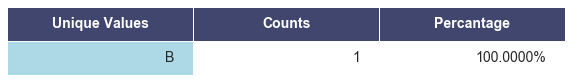

In [41]:
feature_analysis = FeatureAnalysis(df_features,
                                   project_sub_dir=inspect_data_project_dir,
                                   notebook_mode=notebook_mode)
feature_analysis.perform_analysis(df,
                                  dataset_name= "Full " + dataset_name,
                                  target_features=[df_features.target_feature()],
                                  suppress_runtime_errors=False,
                                  display_print=False,
                                  display_visuals=False,
                                  dataframe_snapshot=False)

In [ ]:
del feature_analysis

# Null Analysis of data

In [ ]:
null_analysis = NullAnalysis(df_features,
                             project_sub_dir=inspect_data_project_dir,
                             notebook_mode=notebook_mode)

null_analysis.perform_analysis(df,
                               dataset_name="Full " + dataset_name,
                               null_features_only=True,
                               display_visuals=True,
                               display_print=False,
                               dataframe_snapshot=False)

In [ ]:
missing_table = missing_values_table(df)
display(missing_table)
nan_features = missing_table[missing_table["% of Total Values"] > 15].index.to_list()
print("Above defined percentage:")
display(nan_features)

In [ ]:
null_analysis.feature_analysis_of_null_data(df,
                                            "Full " + dataset_name,
                                            target_features=[df_features.target_feature()],
                                            display_visuals=False,
                                            display_print=False,
                                            save_file=True,
                                            suppress_runtime_errors=True,
                                            aggregate_target_feature=True,
                                            extra_tables=True,
                                            nan_features=nan_features)

In [ ]:
del null_analysis

## Create a json file of df_features

In [ ]:
created_dir = create_dir_structure(os.getcwd(),
                                   f"/eflow Data/{dataset_name}")

In [ ]:
df_features.create_json_file_representation(created_dir,
                                            "df_features.json")

In [ ]:
df_features = DataFrameTypes()
df_features.init_on_json_file(os.getcwd() + f"/eflow Data/{dataset_name}/df_features.json")

In [ ]:
df_features.display_features()

In [ ]:
remove_unconnected_pipeline_segments()

# Test encoding and value reprsentation

In [ ]:
df

In [ ]:
data_encoder.make_values_bool(df,
                              df_features)

In [ ]:
df

In [ ]:
data_encoder.revert_value_representation(df,
                                         df_features)

In [ ]:
df

In [ ]:
data_encoder.encode_data(df,
                         df_features,
                         apply_value_representation=True)

In [ ]:
df

In [ ]:
data_encoder.decode_data(df,
                         df_features,
                         apply_value_representation=True)

In [ ]:
df

In [ ]:
qualtative_features = df_features.string_features() | df_features.categorical_features()

In [ ]:
data_encoder.make_dummies(df,
                          df_features,
                          qualtative_features=qualtative_features)

In [ ]:
df

In [ ]:
data_encoder.revert_dummies(df,
                            df_features,
                            qualtative_features=qualtative_features)

In [ ]:
df